This notebook compares the performance of QAOA with the ALR algorithm for maximum cut on a few types of graphs.

This belongs with the paper:
"Classical algorithms and quantum limitations for maximum cut on high-girth graphs" by Boaz Barak and Kunal Marwaha

(submitted to FOCS 2021, on arXiv at https://arxiv.org/abs/2106.05900 )

All data is available at https://github.com/marwahaha/qaoa-local-competitors/tree/master/qaoa_vs_alr

# Imports

In [1]:
import numpy as np
from scipy.io import loadmat
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from functools import lru_cache
import pandas as pd
from itertools import chain, combinations
import seaborn as sns
sns.set()

# Random graphs

## Working with Leo Zhou's data

The data file `MaxCut_Fourier_u3R.mat` is from:


"Quantum Approximate Optimization Algorithm: Performance, Mechanism,and Implementation on Near-Term Devices"

by Leo Zhou, Sheng-Tao Wang, Soonwon Choi, Hannes Pichler, and Mikhail D. Lukin

https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021067



In [2]:
annots = loadmat('MaxCut_Fourier_u3R.mat')
print(annots.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DataFourier', 'DataFourierRP', 'Ns', 'maxP', 'GraphData', 'numGraphs'])


In [3]:
# fields: ratio, param, overlaps, userTime
[annots['DataFourierRP'][0][0][i].shape for i in range(len(annots['DataFourierRP'][0][0]))]

[(20, 100), (20, 100), (20, 2, 100), (20, 100)]

In [4]:
Ns = annots['Ns'][0]
num_graphs = annots['numGraphs'][0]
maxP = annots['maxP'][0][0]

## Finding the maximum cut

Leo's method (from his code at https://github.com/leologist/GenQAOA/ )

In [5]:
@lru_cache(maxsize=None)
def get_kron(N,i,j):
    sz = [1,-1]
    L = 2**(i-1)
    M = 2**(j-i-1)
    R = 2**(N-j)
    outT1 = np.kron(np.ones(L), sz)
    outT2 = np.kron(outT1, np.ones(M))
    outT3 = np.kron(outT2, sz)
    out = np.kron(outT3, np.ones(R))
    return out

In [6]:
def get_H(N, edges):
    H = np.zeros(2**N)
    for i,j in edges:
        H = H + (1 - get_kron(N, i, j))/2
    return H

Comparing against a brute-force method:

In [7]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [8]:
num_trials = 10

In [9]:
%%time
for N in [8,10,12,14,16]:
    for _ in range(num_trials):
        G = nx.random_regular_graph(3, N)
        G = nx.convert_node_labels_to_integers(G, first_label=1)
        max_cut = max(get_H(N, G.edges()))
        all_subsets = powerset(list(G.nodes()))
        all_cut_sizes = [nx.cut_size(G, S) for S in all_subsets]
        max_cut_brute = max(all_cut_sizes)
#         print("max cut:", max_cut, max_cut_brute)
        assert max_cut == max_cut_brute
print("Success")

Success
CPU times: user 13.6 s, sys: 38.6 ms, total: 13.6 s
Wall time: 13.6 s


## ALR algorithm

In [10]:
def ALR(g):
    # Get adjacency matrix and eigenvectors
    nodes = sorted(g.nodes())
    n = len(nodes)
    m = nx.linalg.graphmatrix.adjacency_matrix(g, nodelist=nodes).asfptype().T.toarray()
    w, v = scipy.linalg.eig(m)
    
    min_eig_idxs = np.where(w == np.min(w))[0]
    cut = 0
    for idx in min_eig_idxs:
    # average over minimum eigenvectors (there are multiple when graph is disconnected, for example)
        eigvec = v[:, idx]
        # normalize eigenvector
        eigvec = eigvec * n**0.5 / np.linalg.norm(eigvec)

        # make cut from sign of eigenvector
        signs = np.sign(eigvec)
        S = [n for n, x in zip(nodes, signs) if x >= 0]
        cut += nx.cut_size(g, S)
    cut = cut/len(min_eig_idxs)
    return cut

## Compare algorithms

In [11]:
@lru_cache(maxsize=None)
def compare(N, p, graph_num, show_prints=True, return_graph=False):
    pr = print if show_prints else lambda *x: x
    
    # get graph
    assert N in Ns, "choose N from 8, 10, 12, 14, 16, 18, 20, 22"
    idx = np.where(Ns == N)[0][0]
    assert annots['GraphData'][0][idx][0] == N
    assert annots['GraphData'][0][idx][2] == 'u3R'
    assert annots['GraphData'][0][idx][1].size == num_graphs[idx]
    pr("N:", N)
    pr("number of graphs:", num_graphs[idx])
    assert graph_num < num_graphs[idx], "graph_num must be less than " + str(num_graphs[idx])
    assert 1 <= p and p <= maxP, "must be p in 1-" + str(maxP)
    pr("p:", p)
    pr("graph num:", graph_num)
    ratio = annots['DataFourierRP'][0][idx][0][p-1][graph_num]
    pr("approx ratio:", ratio)
    graph_edges = annots['GraphData'][0][idx][1][0][graph_num]
    G = nx.parse_edgelist([str(e[0]) + " " + str(e[1]) for e in graph_edges], nodetype = int)
    G = nx.convert_node_labels_to_integers(G, first_label=1)
    
    # get max cut
    max_cut = max(get_H(N, G.edges()))
    pr("total number of edges:", len(graph_edges))
    pr("max cut:", max_cut)
    qaoa_average_cut = ratio*max_cut
    pr("qaoa average cut:", qaoa_average_cut)
    
    # get ALR cut
    alr_cut = ALR(G)
    pr("ALR cut:", alr_cut)
    if return_graph:
        return G
    return (len(graph_edges), max_cut, qaoa_average_cut, alr_cut)

## Go through data

In [12]:
# Example
N = 16
p = 3
graph_num = 20
compare(N, p, graph_num, show_prints=True)

N: 16
number of graphs: 100
p: 3
graph num: 20
approx ratio: 0.898987262169082
total number of edges: 24
max cut: 21.0
qaoa average cut: 18.878732505550722
ALR cut: 20.0


(24, 21.0, 18.878732505550722, 20.0)

In [13]:
%%time

all_df = None
for N in [8, 10, 12, 14, 16]:
    print("N =", N)
    ps = range(1, 21)
    for p in ps:
        df = pd.DataFrame(([(N, p, i, *compare(N, p, i, show_prints=False)) for i in range(100)]), columns=['N', 'p', 'graph_num', 'E', 'max_cut', 'qaoa', 'alr'])
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat((all_df, df))
            
#all_df.to_csv('output.csv', index = False)

N = 8
N = 10
N = 12
N = 14
N = 16
CPU times: user 25.6 s, sys: 16 ms, total: 25.6 s
Wall time: 25.6 s


## Plots

In [14]:
ds = all_df
ds['delta'] = ds['alr'] - ds['qaoa']
ds['normalized_delta'] = ds['delta']/ds['E']
average_diff = ds.groupby(['N','p'])['delta'].mean().unstack()

In [15]:
def plot_mean_diff(average_diff, ax, f1=20, f2=16):
    cmap = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(average_diff, center = 0, cmap=cmap, ax=ax)
    ax.set_title("Mean difference in cut value ($ALR-QAOA$)", fontsize = f1)
    ax.invert_yaxis()
    ax.set_ylabel('$n$', fontsize=f2)
    ax.set_xlabel('$p$', fontsize=f2)

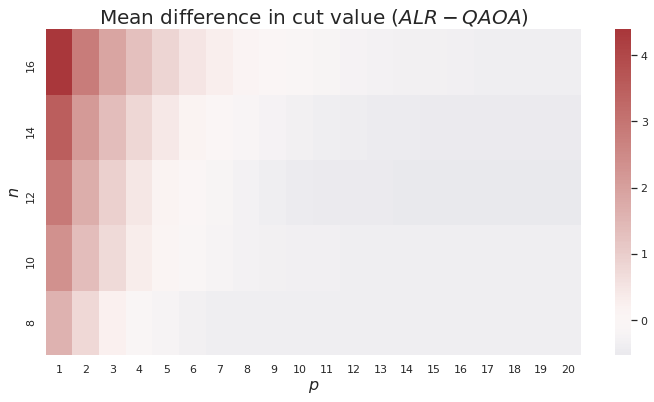

In [16]:
plt.figure(figsize=(12, 6))
ax = plt.axes()

plot_mean_diff(average_diff, ax)
plt.show()

In [17]:
ds['ALR wins'] = ds['delta']>=0
frac_alr_win = ds.groupby(['N','p'])['ALR wins'].mean().unstack()*100

In [18]:
def plot_qaoa_wins(frac_alr_win, ax, f1=20, f2=16):
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    labels = frac_alr_win.applymap(lambda v: "0"  if v == 100 else '')
    sns.heatmap(100-frac_alr_win, vmin = 0, vmax=100, cmap=cmap, ax=ax, annot=labels, fmt="")
    ax.set_title("Percent on which QAOA beats ALR", fontsize=f1)
    ax.invert_yaxis()
    ax.set_ylabel('$n$', fontsize=f2)
    ax.set_xlabel('$p$', fontsize=f2)

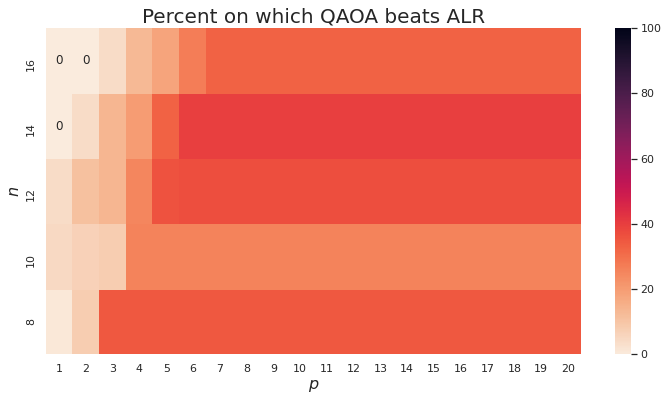

In [19]:
plt.figure(figsize=(12, 6))
ax = plt.axes()

plot_qaoa_wins(frac_alr_win, ax)
plt.show()

In [20]:
THRESHOLD = 0.05
ds['ALR almost wins'] = ds['normalized_delta']>= -THRESHOLD

frac_alr_almost_win = ds.groupby(['N','p'])['ALR almost wins'].mean().unstack()*100

In [21]:
def plot_qaoa_wins_by_margin(frac_alr_almost_win, ax, THRESHOLD, f1=20, f2=16):
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    labels = frac_alr_almost_win.applymap(lambda v: "0"  if v == 100 else '')
    sns.heatmap(100-frac_alr_almost_win, vmin = 0, vmax=100, cmap=cmap, ax=ax, annot=labels, fmt="")

    ax.set_title(f"Percent on which QAOA beats ALR by > {THRESHOLD*100:.0f}%",fontsize =f1)
    ax.invert_yaxis()
    ax.set_ylabel('$n$', fontsize=f2)
    ax.set_xlabel('$p$', fontsize=f2)

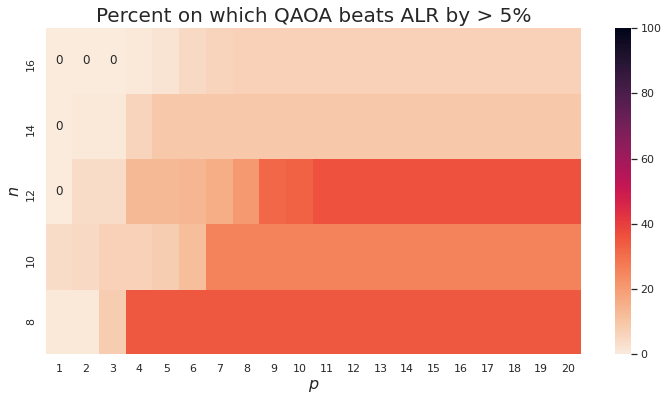

In [22]:
plt.figure(figsize=(12, 6))
ax = plt.axes()

plot_qaoa_wins_by_margin(frac_alr_almost_win, ax, THRESHOLD)
plt.show()

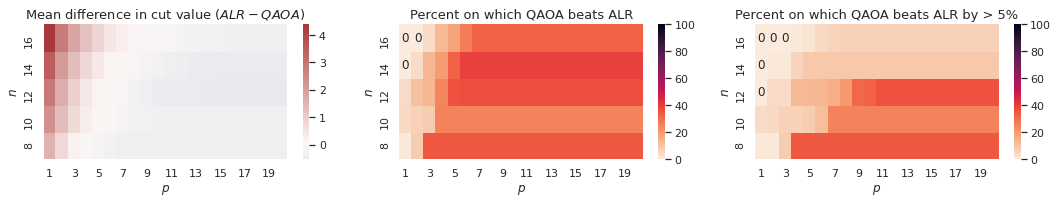

In [23]:
fig, axs = plt.subplots(1, 3, figsize=((15, 3)))
plot_mean_diff(average_diff, axs[0], f1=13, f2=12)
plot_qaoa_wins(frac_alr_win, axs[1], f1=13, f2=12)
plot_qaoa_wins_by_margin(frac_alr_almost_win, axs[2], THRESHOLD, f1=13, f2=12)
fig.tight_layout()
plt.savefig("random.png", dpi=300)

# Torus and grid

In [24]:
G=nx.grid_2d_graph(4,4, periodic=True)
G=nx.convert_node_labels_to_integers(G, first_label=1)
print("4x4 torus", len(G.edges()), max(get_H(len(list(G)), G.edges())), ALR(G))

4x4 torus 32 32.0 32.0


In [25]:
edges = list(G.edges())
with open('torus.txt', 'w') as f:
    for i,j in edges:
        f.write(str(i) + " " + str(j) +  " " + "1\n")
f.close()

In [26]:
G=nx.grid_2d_graph(4,4, periodic=False)
G=nx.convert_node_labels_to_integers(G, first_label=1)
print("4x4 grid", len(G.edges()), max(get_H(len(list(G)), G.edges())), ALR(G))

4x4 grid 24 24.0 24.0


In [27]:
edges = list(G.edges())
with open('grid.txt', 'w') as f:
    for i,j in edges:
        f.write(str(i) + " " + str(j) +  " " + "1\n")
f.close()

The QAOA approximation ratio was found using Leo's code. https://github.com/leologist/GenQAOA/blob/master/MATLAB/demo/demo_QAOAMaxCut_FourierStrategy.m

The data was collected and stored in `grid.csv`.

In [28]:
grid = pd.read_csv('grid.csv')
grid

,m,n,periodic,E,max_cut,p,qaoa_ratio_of_max_cut
0,4,4,True,32,32,1,0.6624
1,4,4,True,32,32,2,0.7541
2,4,4,True,32,32,3,0.8289
3,4,4,True,32,32,4,0.9068
4,4,4,True,32,32,5,0.9562
5,4,4,True,32,32,6,0.9826
6,4,4,True,32,32,7,0.9947
7,4,4,True,32,32,8,0.9985
8,4,4,True,32,32,9,0.9996
9,4,4,True,32,32,10,0.9999


## Plots

In [29]:
torus = grid[grid.periodic==True]
torus

,m,n,periodic,E,max_cut,p,qaoa_ratio_of_max_cut
0,4,4,True,32,32,1,0.6624
1,4,4,True,32,32,2,0.7541
2,4,4,True,32,32,3,0.8289
3,4,4,True,32,32,4,0.9068
4,4,4,True,32,32,5,0.9562
5,4,4,True,32,32,6,0.9826
6,4,4,True,32,32,7,0.9947
7,4,4,True,32,32,8,0.9985
8,4,4,True,32,32,9,0.9996
9,4,4,True,32,32,10,0.9999


In [30]:
torus.set_index(['p'], inplace=True)

In [31]:
def plot_torus(torus, ax, f1=16, f2=12):
    torus['qaoa_ratio_of_max_cut'].plot(ax=ax)
    ax.set_ylim(0.65,1.02)
    ax.set_title("QAOA cut value on $4 \\times 4$ torus", fontsize=f1)
    ax.set_ylabel("Cut value", fontsize=f2)
    ax.set_xlabel("$p$", fontsize=f2)

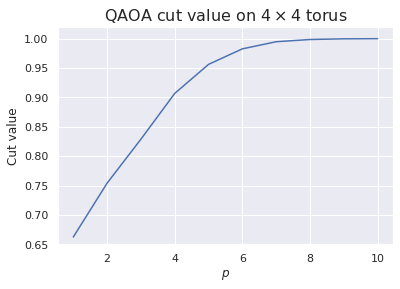

In [32]:
ax = plt.axes()
plot_torus(torus, ax)
plt.show()

In [33]:
grid_4 = grid[grid.periodic==False]
grid_4.set_index(['p'], inplace=True)
grid_4

,m,n,periodic,E,max_cut,qaoa_ratio_of_max_cut
p,,,,,,
1,4,4,False,24,24,0.6879
2,4,4,False,24,24,0.7787
3,4,4,False,24,24,0.8406
4,4,4,False,24,24,0.8849
5,4,4,False,24,24,0.9202
6,4,4,False,24,24,0.9506
7,4,4,False,24,24,0.9720
8,4,4,False,24,24,0.9849
9,4,4,False,24,24,0.9920


In [34]:
def plot_grid(grid_n, ax, f1=16, f2=12):
    grid_n['qaoa_ratio_of_max_cut'].plot(ax=ax)
    ax.set_ylim(0.65,1.02)
    ax.set_title("QAOA cut value on $4 \\times 4$ grid", fontsize=f1)
    ax.set_ylabel("Cut value", fontsize=f2)
    ax.set_xlabel("$p$", fontsize=f2)

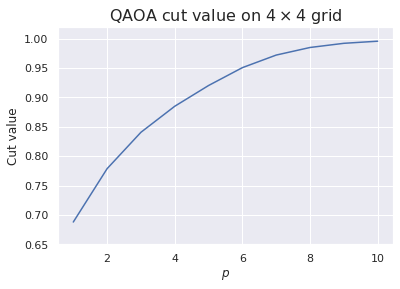

In [35]:
ax = plt.axes()
plot_grid(grid_4, ax)
plt.show()

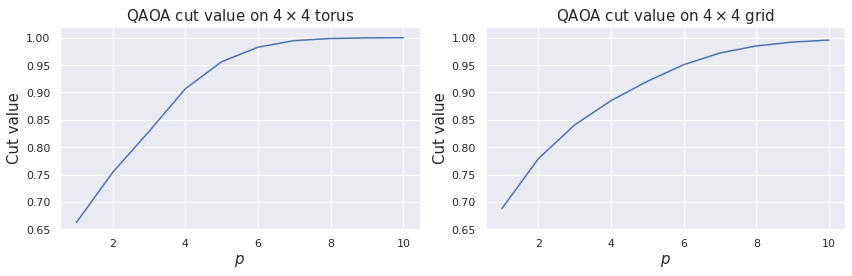

In [36]:
fig, axs = plt.subplots(1, 2, figsize=((12, 4)))
plot_torus(torus, axs[0], f1=15, f2=15)
plot_grid(grid_4, axs[1], f1=15, f2=15)
fig.tight_layout()
plt.savefig("grid.png", dpi=300)

# Union of torus and random graph

0 45 35.0 35.0


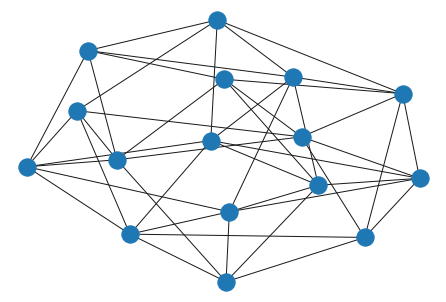

50 47 37.0 36.0


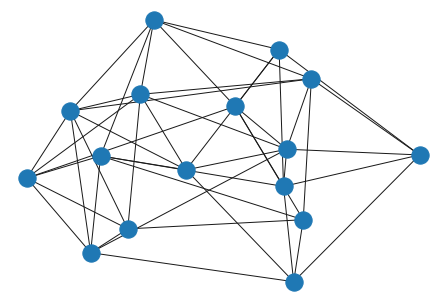

In [37]:
graph_nums = [0,50]
for num in graph_nums:
    G_random = compare(16, 3, num, show_prints=False, return_graph=True)
    G_torus=nx.grid_2d_graph(4,4, periodic=True)
    G_torus = nx.convert_node_labels_to_integers(G_torus, first_label=1)
    assert sorted(list(G_torus.nodes())) == sorted(list(G_random.nodes()))
    union = set(list(G_torus.edges()) + list(G_random.edges()))
    
    with open('union' + str(num) + '.txt', 'w') as f:
        for i,j in union:
            f.write(str(i) + " " + str(j) +  " " + "1\n")
    f.close()
    
    G = G_random.copy()
    G.add_edges_from(G_torus.edges())
    print(num, len(G.edges()), max(get_H(len(list(G)), G.edges())), ALR(G))
    nx.draw(G)
    plt.show()

The QAOA approximation ratio was found using Leo's code. https://github.com/leologist/GenQAOA/blob/master/MATLAB/demo/demo_QAOAMaxCut_FourierStrategy.m

The data was collected and stored in `unions.csv`.

In [38]:
unions = pd.read_csv('unions.csv')
unions

,graph_num,n,p,E,max_cut,alr,qaoa_ratio
0,50,16,1,47,37,36,0.7690
1,50,16,2,47,37,36,0.8390
2,50,16,3,47,37,36,0.8790
3,50,16,4,47,37,36,0.9052
4,50,16,5,47,37,36,0.9255
5,50,16,6,47,37,36,0.9423
6,50,16,7,47,37,36,0.9562
7,50,16,8,47,37,36,0.9674
8,50,16,9,47,37,36,0.9755
9,50,16,10,47,37,36,0.9807


## Plots

In [39]:
unions['qaoa_val'] = unions['max_cut']*unions['qaoa_ratio']/unions['E']
unions['alr_val'] = unions['alr']/unions['E']
unions['opt_val'] = unions['max_cut']/unions['E']

In [40]:
unions1 = unions[unions.graph_num==50]
unions2 = unions[unions.graph_num==0]
unions1.set_index('p',inplace=True)
unions2.set_index('p',inplace=True)

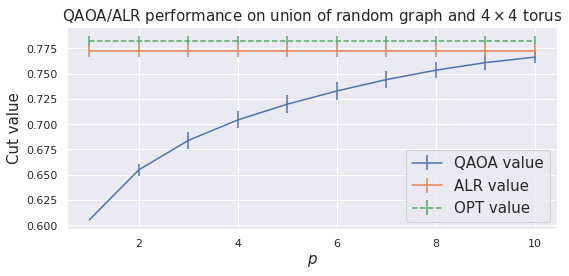

In [41]:
plt.figure(figsize=(8,4))
ax = plt.axes()
mean = (unions1+unions2)/2
low = pd.concat([unions1, unions2]).min(level=0)
high = pd.concat([unions1, unions2]).max(level=0)
ax.errorbar(unions1.index, mean['qaoa_val'],yerr = [(mean-low).qaoa_val,(high-mean).qaoa_val], label="QAOA value")
ax.errorbar(unions1.index, mean['alr_val'],yerr = [(mean-low).alr_val,(high-mean).alr_val], label = "ALR value")
ax.errorbar(unions1.index, mean['opt_val'],yerr = [(mean-low).opt_val,(high-mean).opt_val], label = "OPT value", linestyle ='--')
ax.legend(fontsize = 15)
ax.set_xlabel('$p$',fontsize = 15)
ax.set_ylabel('Cut value', fontsize = 15)
ax.set_title('QAOA/ALR performance on union of random graph and $4 \\times 4$ torus', fontsize = 15)
plt.tight_layout()
plt.savefig('union.png', dpi=300)

Thanks for reading!